 <h1><center>Fuentes de datos</center></h1>

## Librerías

In [1]:
!pip install xarray==0.21.1

In [2]:
!pip install wget

In [3]:
!pip install ecmwflibs

In [4]:
!pip install dask

In [5]:
import os
import datetime 
import pathlib
import numpy as np
import xarray as xr
import pandas as pd
import wget

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cdsapi

import ecmwflibs
import cfgrib

import pygrib
import dask

import warnings
warnings.simplefilter("ignore")

/usr/local/anaconda3/envs/py3_conda/lib/python3.9/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.27.0
  warnings.warn(


## Funciones

In [6]:
def graf_grb(ds,lev,model,out):
    if model == 'ERA5-SF':
        xmin = np.nanmin(ds.longitude.values)
        xmax = np.nanmax(ds.longitude.values)
        ymin = np.nanmin(ds.latitude.values)
        ymax = np.nanmax(ds.latitude.values)
    else: 
        xmin = np.nanmin(ds.sel(isobaricInhPa=lev).longitude.values)
        xmax = np.nanmax(ds.sel(isobaricInhPa=lev).longitude.values)
        ymin = np.nanmin(ds.sel(isobaricInhPa=lev).latitude.values)
        ymax = np.nanmax(ds.sel(isobaricInhPa=lev).latitude.values)

    fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(11,8),subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',edgecolor='face', facecolor='gray',alpha=.2))
    
    ax.axis("off")
    ax.set_global()
    if model == 'NAM':
        lon_grid = np.arange(-180,181,10)
        lat_grid = np.arange(-80,86,10)
    else:
        lon_grid = np.arange(-180,181,60)
        lat_grid = np.arange(-80,86,45)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, xlocs=lon_grid,ylocs=lat_grid,
                      linewidth=.01, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    if (model == 'NAM') | (model == 'ERA5-SF') | (model == 'ERA5-PL'):
        ax.set_extent([xmin, xmax, ymin, ymax])
    if model == 'ERA5-SF':
        mapa = ax.contourf(ds.longitude.values,
                           ds.latitude.values,
                           ds.t2m.values,
                           np.arange(250,310,1),cmap='jet',extend='both')
      
    else:
        mapa = ax.contourf(ds.sel(isobaricInhPa=lev).longitude.values,
                           ds.sel(isobaricInhPa=lev).latitude.values,
                           ds.sel(isobaricInhPa=lev).t.values,
                           np.arange(250,310,1),cmap='jet',extend='both')  

    if model == 'NAM': 
        ax.text(-134,ymax+1,f"{model} Air Temperature {lev} hPa",fontsize=18,fontweight='bold')
    if model == 'ERA5-SF': 
        ax.text(-134,ymax+2,f"{model} Air Temperature 2m",fontsize=18,fontweight='bold')
    else: 
        ax.text(-180,ymax+1,f"{model} Air Temperature {lev} hPa",fontsize=18,fontweight='bold')
    plt.savefig(out,transparent=True,dpi=200,bbox_inches="tight")
    plt.show()

## Global Forecast System (GFS)

### Descarga

- **start_date [datetime]:** Fecha de inicio del pronóstico
- **path_out [pathlib]:** Ruta donde se van a descargar los pronosticos
- **delay_hour [int]:** Número de horas que se van a descargar (multiplo de 3)
- **resolution [str]:** Resolución de GFS (25, 50)

In [7]:
def get_gfs(start_date,path_out,delay_hour,resolution):
    path_tmp = path_out.joinpath(start_date.strftime('%Y%m%d%H'))
    path_tmp.mkdir(parents=True, exist_ok=True)
    url_base = f"https://nomads.ncep.noaa.gov/pub/data/nccf/com/gfs/prod/"
    url_fold = f"gfs.{start_date.strftime('%Y%m%d/%H/atmos/')}"
    list_files = []
    for hour in range(0,delay_hour+3,3):
        file_name = f"gfs.t{start_date.strftime('%H')}z.pgrb2.0p{resolution}.f{hour:03}"
        file_dwnd = wget.download(f"{url_base}{url_fold}{file_name}",str(path_tmp))
        list_files.append(f"{url_base}{url_fold}{file_name}")
        print(file_name)
    return list_files

In [9]:
downloaded_files = get_gfs(
                    start_date=datetime.datetime(2023,11,28,0),
                    path_out=pathlib.Path('/Volumes/phd_data/workshop/dataset/GFS/'),
                    delay_hour=48,
                    resolution='25'
)

gfs.t00z.pgrb2.0p25.f000
gfs.t00z.pgrb2.0p25.f003
gfs.t00z.pgrb2.0p25.f006
gfs.t00z.pgrb2.0p25.f009
gfs.t00z.pgrb2.0p25.f012
gfs.t00z.pgrb2.0p25.f015
gfs.t00z.pgrb2.0p25.f018



KeyboardInterrupt

KeyboardInterrupt



In [ ]:
downloaded_files

### Visualización

In [12]:
path_gfs = pathlib.Path('/Volumes/phd_data/workshop/dataset/GFS/2023111600/')

#### Xarray

In [ ]:
file_name = path_gfs.joinpath('gfs.t00z.pgrb2.0p25.f003')

ds_gfs = xr.load_dataset(
                    filename_or_obj=file_name.as_posix(), 
                    engine="cfgrib",
                    filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
)
ds_gfs

In [15]:
file_name = path_gfs.joinpath('gfs.t00z.pgrb2.0p25.f003')

ds_gfs = xr.load_dataset(
                    filename_or_obj=file_name.as_posix(), 
                    engine="cfgrib",
                    filter_by_keys={'typeOfLevel': 'isobaricInhPa','name':'Temperature'}
)
ds_gfs

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 33, latitude: 721, longitude: 1440)
Coordinates:
    time           datetime64[ns] 2023-11-16
    step           timedelta64[ns] 03:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 975.0 950.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude      (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time     datetime64[ns] 2023-11-16T03:00:00
Data variables:
    t              (isobaricInhPa, latitude, longitude) float32 255.6 ... 287.2
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2023-11-29T15:03 GRIB to CDM+CF via cfgrib-0.9.1...

In [18]:
gfs_path_list = sorted(list(path_gfs.rglob(f'gfs*')))
df_info_gfs = {idd: [ii] for idd, ii in enumerate(gfs_path_list)}
df_info_gfs = pd.DataFrame.from_dict(df_info_gfs, orient='index', columns=['path'])
df_info_gfs

path
0   /Volumes/phd_data/workshop/dataset/GFS/2023111...
1   /Volumes/phd_data/workshop/dataset/GFS/2023111...
2   /Volumes/phd_data/workshop/dataset/GFS/2023111...
3   /Volumes/phd_data/workshop/dataset/GFS/2023111...
4   /Volumes/phd_data/workshop/dataset/GFS/2023111...
5   /Volumes/phd_data/workshop/dataset/GFS/2023111...
6   /Volumes/phd_data/workshop/dataset/GFS/2023111...
7   /Volumes/phd_data/workshop/dataset/GFS/2023111...
8   /Volumes/phd_data/workshop/dataset/GFS/2023111...
9   /Volumes/phd_data/workshop/dataset/GFS/2023111...
10  /Volumes/phd_data/workshop/dataset/GFS/2023111...
11  /Volumes/phd_data/workshop/dataset/GFS/2023111...
12  /Volumes/phd_data/workshop/dataset/GFS/2023111...
13  /Volumes/phd_data/workshop/dataset/GFS/2023111...
14  /Volumes/phd_data/workshop/dataset/GFS/2023111...
15  /Volumes/phd_data/workshop/dataset/GFS/2023111...
16  /Volumes/phd_data/workshop/dataset/GFS/2023111...

In [19]:
mds_gfs = xr.open_mfdataset(
              paths=df_info_gfs.path.to_list(),
              engine="cfgrib",
              filter_by_keys={
                      'typeOfLevel': 'heightAboveGround',
                      'name':'2 metre temperature'
                              },
              chunks = {'time': -1, 'lat': 'auto', 'lon': 'auto'},
              combine='nested',
              concat_dim='valid_time'
)

In [ ]:
mds_gfs

In [ ]:
df_t2m_forecast = mds_gfs.sel(longitude=284.41, latitude=6.26, method='nearest').compute().to_dataframe()

In [ ]:
df_t2m_forecast.t2m.plot()

In [ ]:
mds_gfs = xr.open_mfdataset(
    paths=df_info_gfs[1:].path.to_list(),
    engine="cfgrib",
    filter_by_keys={
        'typeOfLevel': 'surface',
        'name': 'Total Precipitation'
    },
    chunks={'time': -1, 'lat': 'auto', 'lon': 'auto'},
    combine='nested',
    concat_dim='valid_time',
)

In [20]:
mds_gfs

<xarray.Dataset>
Dimensions:            (valid_time: 17, latitude: 721, longitude: 1440)
Coordinates:
    time               datetime64[ns] 2023-11-16
    step               (valid_time) timedelta64[ns] 00:00:00 ... 2 days 00:00:00
    heightAboveGround  float64 2.0
  * latitude           (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude          (longitude) float64 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * valid_time         (valid_time) datetime64[ns] 2023-11-16 ... 2023-11-18
Data variables:
    t2m                (valid_time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2023-11-29T15:08 GRIB to CDM+CF via cfgrib-0.9.1...

In [21]:
df_tp_forecast = mds_gfs.sel(longitude=284.41, latitude=6.26, method='nearest').compute().to_dataframe()

<AxesSubplot:xlabel='valid_time'>

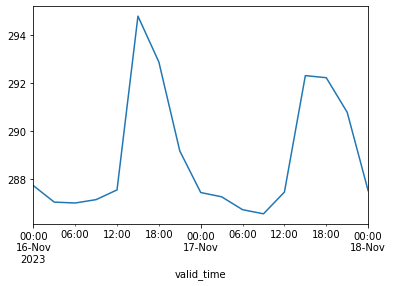

In [23]:
df_tp_forecast.t2m.plot()

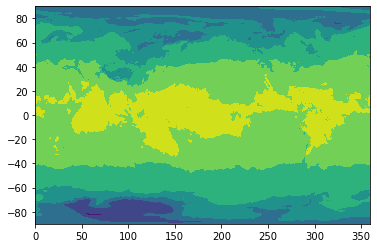

In [24]:
plt.contourf(mds_gfs.longitude.data,mds_gfs.latitude.data,mds_gfs.isel(valid_time=0).t2m.compute().data)

In [ ]:
def convert_longitude_to_0_360(lon):
    return (lon + 360) % 360

In [ ]:
convert_longitude_to_0_360(-75.589536)

#### Pygrib

In [13]:
file_name = path_gfs.joinpath('gfs.t00z.pgrb2.0p25.f003')
gb_gfs = pygrib.open(file_name.as_posix())
for grb in gb_gfs:
    print(grb.name, grb.typeOfLevel, grb.level, grb.units)

Pressure reduced to MSL meanSea 0 Pa
Cloud mixing ratio hybrid 1 kg kg**-1
Ice water mixing ratio hybrid 1 kg kg**-1
Rain mixing ratio hybrid 1 kg kg**-1
Snow mixing ratio hybrid 1 kg kg**-1
Graupel (snow pellets) hybrid 1 kg kg**-1
Derived radar reflectivity hybrid 1 dB
Derived radar reflectivity hybrid 2 dB
Maximum/Composite radar reflectivity atmosphere 0 dB
Visibility surface 0 m
U component of wind planetaryBoundaryLayer 0 m s**-1
V component of wind planetaryBoundaryLayer 0 m s**-1
Ventilation Rate planetaryBoundaryLayer 0 m**2 s**-1
Wind speed (gust) surface 0 m s**-1
Geopotential height isobaricInPa 1 gpm
Temperature isobaricInPa 1 K
Relative humidity isobaricInPa 1 %
Specific humidity isobaricInPa 1 kg kg**-1
Vertical velocity isobaricInPa 1 Pa s**-1
Geometric vertical velocity isobaricInPa 1 m s**-1
U component of wind isobaricInPa 1 m s**-1
V component of wind isobaricInPa 1 m s**-1
Absolute vorticity isobaricInPa 1 s**-1
Ozone mixing ratio isobaricInPa 1 kg kg**-1
Geopotent

In [14]:
grb.keys()

['globalDomain',
 'GRIBEditionNumber',
 'tablesVersionLatestOfficial',
 'tablesVersionLatest',
 'grib2divider',
 'angleSubdivisions',
 'missingValue',
 'ieeeFloats',
 'isHindcast',
 'section0Length',
 'identifier',
 'discipline',
 'editionNumber',
 'totalLength',
 'sectionNumber',
 'section1Length',
 'numberOfSection',
 'centre',
 'centreDescription',
 'subCentre',
 'tablesVersion',
 'masterDir',
 'localTablesVersion',
 'significanceOfReferenceTime',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'second',
 'dataDate',
 'julianDay',
 'dataTime',
 'productionStatusOfProcessedData',
 'typeOfProcessedData',
 'md5Section1',
 'selectStepTemplateInterval',
 'selectStepTemplateInstant',
 'stepType',
 'is_chemical',
 'is_chemical_distfn',
 'is_chemical_srcsink',
 'is_aerosol',
 'is_aerosol_optical',
 'setCalendarId',
 'deleteCalendarId',
 'sectionNumber',
 'grib2LocalSectionPresent',
 'deleteLocalDefinition',
 'sectionNumber',
 'gridDescriptionSectionPresent',
 'section3Length',
 'numberOfSec

In [ ]:
grb_data = gb_gfs.select(name='Total Precipitation')

In [ ]:
grb_data

In [26]:
file_name = path_gfs.joinpath('gfs.t00z.pgrb2.0p25.f003')

ds_gfs = xr.load_dataset(
                    filename_or_obj=file_name.as_posix(), 
                    engine="cfgrib",
                    filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
                        )

skipping variable: paramId==228164 shortName='tcc'
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/py3_conda/lib/python3.9/site-packages/cfgrib/dataset.py", line 680, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/usr/local/anaconda3/envs/py3_conda/lib/python3.9/site-packages/cfgrib/dataset.py", line 611, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,   15.,
         10.,    7.,    5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,


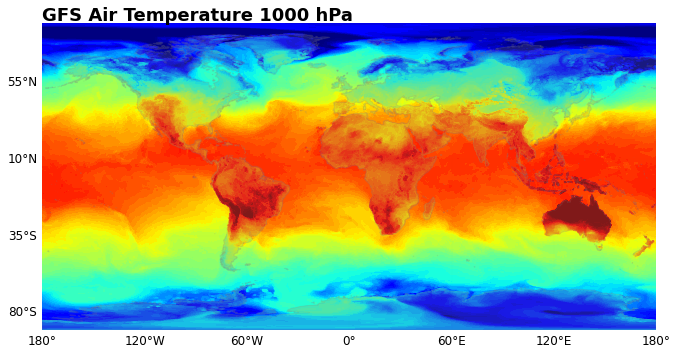

In [25]:
graf_grb(ds=ds_gfs,
         lev=1000,
         model='GFS',
         out='graf_gfs.png')

## North American Mesoscale (NAM)

### Descarga

- **start_date [datetime]:** Fecha de inicio del pronóstico
- **path_out [pathlib]:** Ruta donde se van a descargar los pronosticos
- **delay_hour [int]:** Número de horas que se van a descargar (multiplo de 3)
- **domain [str]:** Nombre del dominio (conusnest.hires, alaskanest.hires, hawaiinest.hires)

In [ ]:
def get_nam(start_date,path_out,delay_hour,domain):
    path_tmp = path_out.joinpath(start_date.strftime('%Y%m%d%H'))
    path_tmp.mkdir(parents=True, exist_ok=True)
    url_base = f"https://nomads.ncep.noaa.gov/pub/data/nccf/com/nam/prod/"
    url_fold = f"nam.{start_date.strftime('%Y%m%d/')}"
    list_files = []
    for hour in range(0,delay_hour+1,1):
        file_name = f"nam.t{start_date.strftime('%H')}z.{domain}f{hour:02}.tm00.grib2"
        file_dwnd = wget.download(f"{url_base}{url_fold}{file_name}",str(path_tmp))
        list_files.append(f"{url_base}{url_fold}{file_name}")
        print(file_name)
    return list_files

In [ ]:
downloaded_files = get_nam(
    start_date=datetime.datetime(2023,11,16,0),
    path_out=pathlib.Path('/Volumes/phd_data/workshop/dataset/NAM/'),
    delay_hour=4,
    domain='conusnest.hires'
)

In [ ]:
path_nam = pathlib.Path('/Volumes/phd_data/workshop/dataset/NAM/2023111600/')

In [ ]:
file_name = path_nam.joinpath('nam.t00z.conusnest.hiresf01.tm00.grib2')
gb_gfs = pygrib.open(file_name.as_posix())
for grb in gb_gfs:
    print(grb.name, grb.typeOfLevel, grb.level, grb.units)

In [ ]:
grb.keys()

In [ ]:
file_name = path_nam.joinpath('nam.t00z.conusnest.hiresf01.tm00.grib2')

ds_nam = xr.load_dataset(
    filename_or_obj=file_name.as_posix(), 
    engine="cfgrib",
    filter_by_keys={
        'typeOfLevel': 'isobaricInhPa',
        'name':'Temperature'
    }
)

In [ ]:
ds_nam

In [ ]:
graf_grb(
    ds=ds_nam,
    lev=1000,
    model='NAM',
    out='graf_nam.png'
)

## Final global tropospheric analyses (FNL)

In [29]:
path_fnl = pathlib.Path('/Volumes/phd_data/workshop/dataset/FNL/')

### Visualización

In [28]:
file_name = path_fnl.joinpath('fnl_20231101_06_00.grib2')

ds_fnl = xr.load_dataset(
    filename_or_obj=file_name.as_posix(),
    engine="cfgrib",
    filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
)

Can't create file '/Volumes/phd_data/workshop/dataset/FNL/fnl_20231101_06_00.grib2.923a8.idx'
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/py3_conda/lib/python3.9/site-packages/cfgrib/messages.py", line 273, in itervalues
    yield self.filestream.message_from_file(file, errors=errors)
  File "/usr/local/anaconda3/envs/py3_conda/lib/python3.9/site-packages/cfgrib/messages.py", line 340, in message_from_file
    return Message.from_file(file, offset, **kwargs)
  File "/usr/local/anaconda3/envs/py3_conda/lib/python3.9/site-packages/cfgrib/messages.py", line 104, in from_file
    raise EOFError("End of file: %r" % file)
EOFError: End of file: <_io.BufferedReader name='/Volumes/phd_data/workshop/dataset/FNL/fnl_20231101_06_00.grib2'>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/py3_conda/lib/python3.9/site-packages/cfgrib/messages.py", line 535, in from_indexpath_or_filestr

EOFError: No valid message found: '/Volumes/phd_data/workshop/dataset/FNL/fnl_20231101_06_00.grib2'

In [ ]:
ds_fnl

In [ ]:
file_name = path_fnl.joinpath('fnl_20231101_06_00.grib2')
gb_gfs = pygrib.open(file_name.as_posix())
for grb in gb_gfs:
    print(grb.name, grb.typeOfLevel, grb.level, grb.units)

In [ ]:
graf_grb(
    ds=ds_fnl,
    lev=1000,
    model='FNL',
    out='graf_fnl.png'
)

## Fifth generation ECMWF reanalysis (ERA5)

### Descarga

In [31]:
def dwd_sf(year,month,day,hour,lonmin,lonmax,latmin,latmax,path_out):
    c = cdsapi.Client()
    name = f"era5_sf_{year}{month}{day}_{hour}.grib2"
    area = f"{latmax}/{lonmin}/{latmin}/{lonmax}"
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
        'variable': [
                    '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature',
                    '2m_temperature', 'land_sea_mask', 'mean_sea_level_pressure',
                    'sea_ice_cover', 'sea_surface_temperature', 'skin_temperature', 'snow_depth',
                    'soil_temperature_level_1', 'soil_temperature_level_2', 'soil_temperature_level_3',
                    'soil_temperature_level_4', 'surface_pressure', 'volumetric_soil_water_layer_1',
                    'volumetric_soil_water_layer_2', 'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4',
                    ],
        'product_type':'reanalysis',
        'area':area,		#N/W/S/E
        'year':year,
        'month':month,
        'day':day,
        'time':hour,
        'format':'grib'
        },
        path_out.joinpath(name).as_posix())
    return

def dwd_pl(year,month,day,hour,lonmin,lonmax,latmin,latmax,path_out):
    c = cdsapi.Client()
    name = f"era5_pl_{year}{month}{day}_{hour}.grib2"
    area = f"{latmax}/{lonmin}/{latmin}/{lonmax}"
    c.retrieve(
        'reanalysis-era5-pressure-levels',
        {
        'variable': [
                    'geopotential', 'relative_humidity', 'temperature',
                    'u_component_of_wind', 'v_component_of_wind',
                    ],
        'pressure_level': [
                          '50', '100', '150', 
                          '200', '250', '300',
                          '350', '400', '450', 
                          '500', '550', '600', 
                          '650', '700', '750', 
                          '775', '800', '825',
                          '850', '875', '900', 
                          '925', '950', '975',
                          '1000'
                            ],
        'product_type':'reanalysis',
        'area':area,		#N/W/S/E
        'year':year,
        'month':month,
        'day':day,
        'time':hour,
        'format':'grib'
        },
        path_out.joinpath(name).as_posix())
    return

In [32]:
path_era = pathlib.Path('/Volumes/phd_data/workshop/dataset/ERA5/')
hour = ['00','06','12','18']
days = ['01','02','03']

for dd in days:
    for hh in hour:
        dwd_sf(
            year='2023',month='01',day=dd,hour=hh,
            lonmin='-180',lonmax='0',latmin='-45',latmax='45',
            path_out=path_era
        )

        dwd_pl(
            year='2023',month='01',day=dd,hour=hh,
            lonmin='-180',lonmax='0',latmin='-45',latmax='45',
            path_out=path_era
        )

2023-11-29 16:22:15,403 INFO Welcome to the CDS
2023-11-29 16:22:15,404 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-29 16:22:15,864 INFO Request is queued
2023-11-29 16:22:17,113 INFO Request is running
2023-11-29 16:22:18,814 INFO Request is completed
2023-11-29 16:22:18,815 INFO Downloading https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data7/adaptor.mars.internal-1701292937.6874197-7121-6-b0c7b882-5ac1-42c0-9725-02d8f52d7a13.grib to /Volumes/phd_data/workshop/dataset/ERA5/era5_sf_20230101_00.grib2 (9.8M)
2023-11-29 16:22:54,858 INFO Download rate 279K/s   
2023-11-29 16:22:55,274 INFO Welcome to the CDS
2023-11-29 16:22:55,280 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2023-11-29 16:22:55,560 INFO Request is queued
2023-11-29 16:22:56,760 INFO Request is running
2023-11-29 16:23:00,980 INFO Request is completed
2023-11-29 16

KeyboardInterrupt: 

### Visualización

#### Niveles de presión 

In [33]:
file_name = path_era.joinpath('era5_pl_20230101_06.grib2')

ds_era = xr.load_dataset(
            filename_or_obj=file_name.as_posix(), 
            engine="cfgrib",
)

In [34]:
ds_era

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 25, latitude: 361, longitude: 721)
Coordinates:
    number         int64 0
    time           datetime64[ns] 2023-01-01T06:00:00
    step           timedelta64[ns] 00:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 975.0 950.0 ... 100.0 50.0
  * latitude       (latitude) float64 45.0 44.75 44.5 ... -44.5 -44.75 -45.0
  * longitude      (longitude) float64 -180.0 -179.8 -179.5 ... -0.5 -0.25 0.0
    valid_time     datetime64[ns] 2023-01-01T06:00:00
Data variables:
    z              (isobaricInhPa, latitude, longitude) float32 -541.8 ... 2....
    r              (isobaricInhPa, latitude, longitude) float32 66.52 ... 1.485
    t              (isobaricInhPa, latitude, longitude) float32 277.5 ... 215.7
    u              (isobaricInhPa, latitude, longitude) float32 11.89 ... 4.687
    v              (isobaricInhPa, latitude, longitude) float32 -6.072 ... 3.213
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-11-29T16:26 GRIB to CDM+CF via cfgrib-0.9.1...

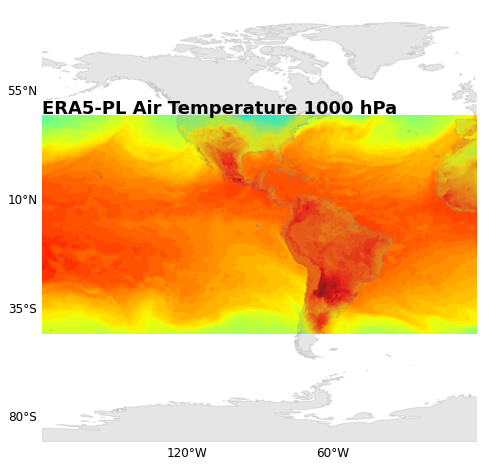

In [35]:
graf_grb(
    ds=ds_era,
    lev=1000,
    model='ERA5-PL',
    out='graf_era5pl.png'
)

#### Superficial 

In [36]:
file_name = path_era.joinpath('era5_sf_20230101_06.grib2')

ds_era = xr.load_dataset(
            filename_or_obj=file_name.as_posix(), 
            engine="cfgrib",
)

skipping variable: paramId==170 shortName='stl2'
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/py3_conda/lib/python3.9/site-packages/cfgrib/dataset.py", line 680, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/usr/local/anaconda3/envs/py3_conda/lib/python3.9/site-packages/cfgrib/dataset.py", line 611, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==183 shortName='stl3'
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/py3_conda/lib/python3.9/site-packages/cfgrib/dataset.py", line 680, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/usr/local/anaconda3/envs/py3_conda/lib/python3.9/site-packages/cfgrib/dataset.py", line 611, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.Dataset

In [37]:
ds_era

<xarray.Dataset>
Dimensions:              (latitude: 361, longitude: 721)
Coordinates:
    number               int64 0
    time                 datetime64[ns] 2023-01-01T06:00:00
    step                 timedelta64[ns] 00:00:00
    surface              float64 0.0
  * latitude             (latitude) float64 45.0 44.75 44.5 ... -44.75 -45.0
  * longitude            (longitude) float64 -180.0 -179.8 -179.5 ... -0.25 0.0
    valid_time           datetime64[ns] 2023-01-01T06:00:00
    depthBelowLandLayer  float64 0.0
Data variables: (12/13)
    u10                  (latitude, longitude) float32 11.92 12.13 ... 3.0 3.194
    v10                  (latitude, longitude) float32 -6.082 -5.886 ... -3.15
    d2m                  (latitude, longitude) float32 272.9 272.9 ... 279.4
    t2m                  (latitude, longitude) float32 278.5 278.6 ... 280.4
    lsm                  (latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0
    msl                  (latitude, longitude) float32 9.932e+04 ... 1.019e+05
    ...                   ...
    sst                  (latitude, longitude) float32 282.6 282.5 ... 281.0
    skt                  (latitude, longitude) float32 282.5 282.4 ... 279.9
    sd                   (latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0
    stl1                 (latitude, longitude) float32 282.6 282.5 ... 281.0
    sp                   (latitude, longitude) float32 9.932e+04 ... 1.019e+05
    swvl1                (latitude, longitude) float32 8.985e-06 ... 8.985e-06
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-11-29T16:27 GRIB to CDM+CF via cfgrib-0.9.1...

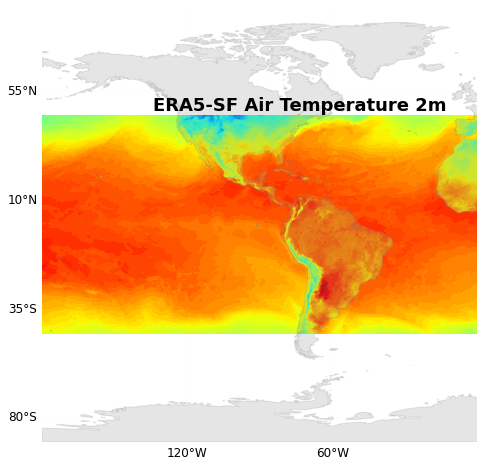

In [38]:
graf_grb(
    ds=ds_era,
    lev=1000,
    model='ERA5-SF',
    out='graf_era5sf.png'
)

In [6]:
path_cmip.as_posix()

NameError: name 'path_cmip' is not defined

In [7]:
path_cmip = pathlib.Path('/Volumes/phd_data/workshop/dataset/CMIP6/')
file_name = path_cmip.joinpath('791587189614968832.txt')

In [8]:
file_name.as_posix()

'/Volumes/phd_data/workshop/dataset/CMIP6/791587189614968832.txt'

In [ ]:
with open(file_name, 'r') as file:
    for idd, line in enumerate(file):
        if idd <= 10:
            print(line.strip())
            try:
                wget.download(line.strip(),path_cmip.as_posix())
            except:
                print ('FALLE')
                pass

https://download.scidb.cn/download?fileId=61b95de78bba886bd1c5216a&dataSetType=personal&username=mzapatahe@unal.edu.co&fileName=atm_hist_1993_04.nc4
https://download.scidb.cn/download?fileId=61b95de78bba886bd1c5216b&dataSetType=personal&username=mzapatahe@unal.edu.co&fileName=atm_hist_2012_01.nc4
https://download.scidb.cn/download?fileId=61b95de78bba886bd1c5216c&dataSetType=personal&username=mzapatahe@unal.edu.co&fileName=atm_hist_2002_05.nc4
https://download.scidb.cn/download?fileId=61b95de78bba886bd1c5216d&dataSetType=personal&username=mzapatahe@unal.edu.co&fileName=atm_hist_2014_05.nc4
https://download.scidb.cn/download?fileId=61b95de78bba886bd1c5216e&dataSetType=personal&username=mzapatahe@unal.edu.co&fileName=atm_hist_2008_12.nc4
https://download.scidb.cn/download?fileId=61b95de78bba886bd1c5216f&dataSetType=personal&username=mzapatahe@unal.edu.co&fileName=atm_hist_1988_10.nc4
